In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib


In [11]:
# Load dataset
df = pd.read_csv('../data/train.csv').dropna()
df.head()


,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...


In [12]:
import re
import string

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text.strip()

df["cleaned_text"] = df["Context"].apply(preprocess)


In [13]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = vectorizer.fit_transform(df["cleaned_text"])


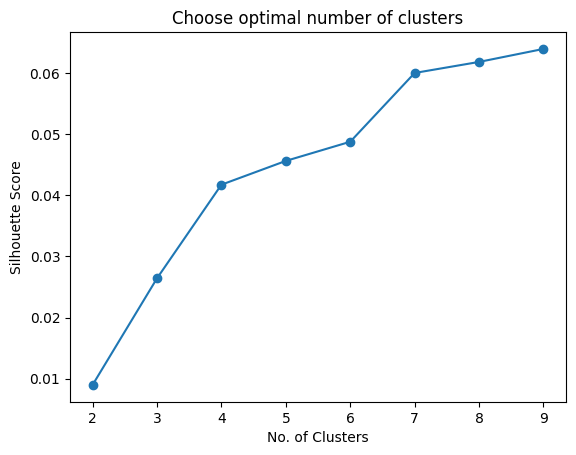

In [16]:
from sklearn.metrics import silhouette_score

# Try different clusters (optional tuning)
scores = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_tfidf)
    score = silhouette_score(X_tfidf, km.labels_)
    scores.append(score)

# Plot silhouette scores to choose best K (optional)
plt.plot(range(2, 10), scores, marker='o')
plt.xlabel('No. of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Choose optimal number of clusters')
plt.show()


In [17]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_tfidf)


In [30]:
kmeans

,n_clusters,6
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [24]:
import numpy as np

terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(k):
    print(f"\nCluster {i} top words:")
    print(", ".join([terms[ind] for ind in order_centroids[i, :10]]))



Cluster 0 top words:
im, help, need, smoking, drinking, girlfriend, just, hard, quit, breakup

Cluster 1 top words:
counseling, does, address, history, ve, issues, terminate, client, decide, counselor

Cluster 2 top words:
feel, dont, know, im, like, want, just, relationship, really, things

Cluster 3 top words:
therapy, normal, everytime, shaky, walk, nervous, far, gone, sessions, couple

Cluster 4 top words:
having, thoughts, feeling, anxiety, im, sex, month, voices, started, attacks

Cluster 5 top words:
time, years, child, told, family, just, sex, says, love, relationship


In [25]:
cluster_to_category = {
    0: "Directive",        # Seeks help or behavioral advice
    1: "Cognitive",        # Analytical queries
    2: "Emotional",        # Expressing confusion and feelings
    3: "Supportive",       # Talking about therapy and shared experience
    4: "High Distress",    # Serious anxiety, hallucinations, etc.
    5: "Neutral"           # Informational/family context
}

df['category'] = df['cluster'].map(cluster_to_category)


In [22]:
print(df["category"].value_counts())
df[['Context', 'category']].head(10)



category
Supportive    1314
Other         1302
Neutral        384
Emotional      221
Directive      175
Cognitive      112
Name: count, dtype: int64


,Context,category
0,I'm going through some things with my feelings...,Supportive
1,I'm going through some things with my feelings...,Supportive
2,I'm going through some things with my feelings...,Supportive
3,I'm going through some things with my feelings...,Supportive
4,I'm going through some things with my feelings...,Supportive
5,I'm going through some things with my feelings...,Supportive
6,I'm going through some things with my feelings...,Supportive
7,I'm going through some things with my feelings...,Supportive
8,I'm going through some things with my feelings...,Supportive
9,I'm going through some things with my feelings...,Supportive


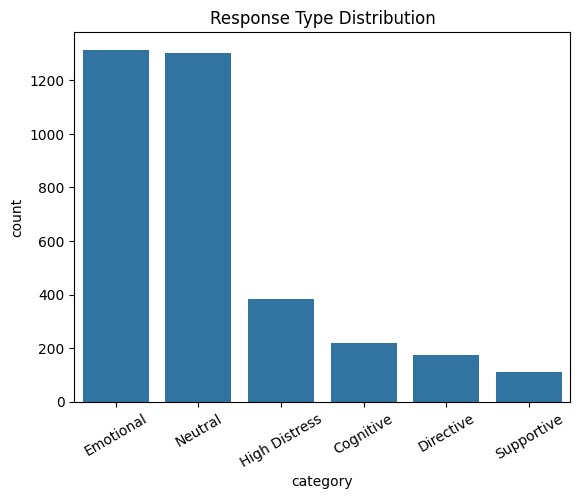

In [29]:
sns.countplot(data=df, x='category', order=df['category'].value_counts().index)
plt.title("Response Type Distribution")
plt.xticks(rotation=30)
plt.show()


In [33]:
import os
import joblib

# Create the model directory if not present (relative from notebook)
os.makedirs('../model', exist_ok=True)

# Save the trained model and vectorizer
joblib.dump(kmeans, '../model/classifier.pkl')
joblib.dump(vectorizer, '../model/vectorizer.pkl')

print("✅ Model and vectorizer saved to /model/")


✅ Model and vectorizer saved to /model/
